In [29]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [30]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('cifar10', split= ['train', 'test'], data_dir="data\\", as_supervised=True)

In [31]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  #Look at shapes images and labels of dataset
  print("length train: ",len(train_ds))
  print("length train: ",len(test_ds))

  x = 0
  for i in train_ds_numpy:
    x += 1
    print(i)
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print("shape ",format(i[0].shape))
    print("max ",np.amax(i[0]))
    print("min ",np.amin(i[0]))
    print(format(i[1]))
    if x == 3:
      break

In [32]:
def plot_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  # Plot 5 samples with their corresponding label.
  fig, ax = plt.subplots(1,5)
  x = 0
  for j in train_ds_numpy:
    
    # Readout an image and the corresponding label.
    img = j[0]

    label = {
        0 : 'airplane',
        1 : 'automobile',
        2 : 'bird',
        3 : 'cat',
        4 : 'deer',
        5 : 'dog',
        6 : 'frog',
        7 : 'horse',
        8 : 'ship',
        9 : 'truck'
    }
    # if label is still just an integer
    if isinstance(j[1], np.int64):
      lbl = label[j[1]]
    # if label is already an one-hot vektor
    else:
      indice = np.where(j[1] == 1)
      indice = indice[0]
      lbl = label[int(indice)]

    ax[x].imshow(img)
    ax[x].set_title(lbl)
    ax[x].axis("off")

    x += 1

    if x==5:
      break

length train:  50000
length train:  10000
(array([[[-0.04053185, -0.77869266, -1.1870369 ],
        [-0.07194295, -0.77869266, -1.1556258 ],
        [-0.16617624, -0.8258093 , -1.1556258 ],
        ...,
        [-0.77869266, -1.70532   , -1.98802   ],
        [-0.6373427 , -1.6267923 , -2.0037255 ],
        [-0.6530483 , -1.6896144 , -1.9723144 ]],

       [[-0.2761151 , -0.74728155, -0.8415148 ],
        [ 0.0065848 , -0.43317056, -0.52740383],
        [ 0.38351798, -0.00912075, -0.11905959],
        ...,
        [-0.59022605, -1.5796757 , -1.8780811 ],
        [-0.52740383, -1.5953811 , -1.9094921 ],
        [-0.52740383, -1.6424978 , -1.9409033 ]],

       [[-0.8258093 , -1.2027425 , -1.1085092 ],
        [-0.43317056, -0.77869266, -0.7001649 ],
        [ 0.5248679 ,  0.22646248,  0.25787356],
        ...,
        [-0.2761151 , -1.218448  , -1.5482645 ],
        [-0.32323173, -1.3283869 , -1.6267923 ],
        [-0.37034836, -1.359798  , -1.673909  ]],

       ...,

       [[ 0.65051

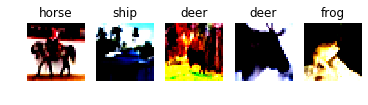

In [33]:
#Build input pipeline
train_ds = train_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))
test_ds = test_ds.map(lambda image, label: (tf.image.per_image_standardization(tf.cast(image, tf.float32)), tf.reshape(tf.one_hot(label, 10), (-1,))))

overview_data()
plot_data()

prefetch_size = tf.data.experimental.AUTOTUNE
print("Autotune: ",prefetch_size)

# batching, shuffle und prefetching
train_ds = train_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)
test_ds = test_ds.batch(64).shuffle(buffer_size=64).prefetch(prefetch_size)

# Resnet

In [34]:
class ResidualBlock(Layer):

    def __init__(self,channels,maps):
        super(ResidualBlock, self).__init__()
        self.channels = channels
        self.maps = maps
        self.conv_1 = tf.keras.layers.Conv2D(filters = maps,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, channels))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.conv_2 = tf.keras.layers.Conv2D(filters = maps,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)

        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_2 = tf.keras.activations.relu

        self.conv_3 = tf.keras.layers.Conv2D(filters = channels,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_3 = tf.keras.activations.relu

    @tf.function
    def call(self,x,training):
        inp = x
        # print(f"ResBlock: channels {self.channels}, maps {self.maps}")

        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_2(x,training=training)
        x = self.activ_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x,training=training)
        x = self.activ_3(x)

        x = tf.add(inp,x)
        x = tf.keras.activations.relu(x)

        return x


In [35]:
class ResNet(Model):
    def __init__(self,blocks,channels,maps):
        # blocks = how many Resblocks
        # channels = how many filters to start with, halves each layer
        # maps = how many maps each layer adds, doubles with each layer
        # template was https://i.imgur.com/hiFrQaC.png
        super(ResNet, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters = channels,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.blocks=[]
        for i in range(0,blocks):
            self.blocks.append(ResidualBlock(channels,maps))
            print(channels," ",maps)
            channels = channels/2
            self.blocks.append(tf.keras.layers.Conv2D(filters = channels, kernel_size = 1)) #totodo: batch norm after pooling
            maps = maps*2
            if i != blocks-1:
                self.blocks.append(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
            

        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)



    @tf.function
    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)

        for i in self.blocks:
            x = i(x,training=training)
            

        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)
        
        return x



# DenseNet

In [36]:
class TransitionLayer(Layer):

    def __init__(self,growth_rate):
        super(TransitionLayer, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = growth_rate,
                                         kernel_size = 1,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu
        
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2),strides=2)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()


    def call(self,x,training):
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        x = self.pool1(x)
        x = self.batch_norm_2(x,training=training)

        return x


In [37]:
class DenseBlock(Layer):

    def __init__(self):
        super(DenseBlock, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = 12,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3)
                                         #input_shape = (32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.conv_2 = tf.keras.layers.Conv2D(filters = 12,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3))
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_2 = tf.keras.activations.relu

        self.conv_3 = tf.keras.layers.Conv2D(filters = 12,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))        # (3))
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_3 = tf.keras.activations.relu     

    #@tf.function
    def call(self,x,training):
        inp = x
        # print(f"ResBlock: channels {self.channels}, maps {self.maps}")

        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)
        
        x = self.conv_2(x)
        x = self.batch_norm_2(x,training=training)
        x = self.activ_2(x)

        x = self.conv_3(x)
        x = self.batch_norm_3(x,training=training)
        x = self.activ_3(x)

        x = tf.keras.layers.concatenate([x,inp])
        #x = tf.concat(x,inp)

        return x

In [38]:
class DenseNet(Model):

    def __init__(self,blocks,growth_rate):
        super(DenseNet, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters = growth_rate*2,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (64, 32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        growth_rate = growth_rate*3 #2 times from first layer, then another one for after 1st block

        self.blocks=[]
        for i in range(0,blocks):
            self.blocks.append(DenseBlock())
            self.blocks.append(TransitionLayer(growth_rate))
            growth_rate += growth_rate


        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)


    def call(self,x,training):
        
        x = self.conv_1(x)
        x = self.batch_norm_1(x,training=training)
        x = self.activ_1(x)

        for i in self.blocks:
            x = i(x,training=training)
            

        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)

        return x

# Model Execution Section

In [39]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  with tf.GradientTape() as tape:
    prediction = model(data, training = True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss 


def test_step(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test_data:
    prediction = model(data, training = False)
    
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [40]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

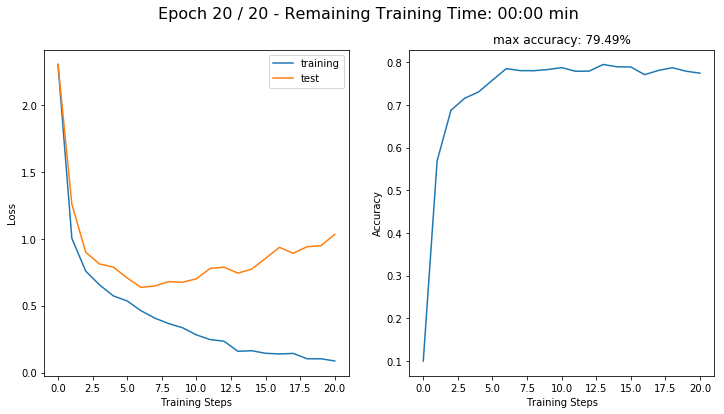

In [27]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 20
learning_rate = tf.optimizers.schedules.ExponentialDecay(0.001, 5000, 0.97, staircase=True)
running_average_factor = 0.95

# Initialize the model.
# model = ResNet(3,128,32) #blocks, channels, maps
model = DenseNet(3,32) #growth_rate


# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train_ds:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

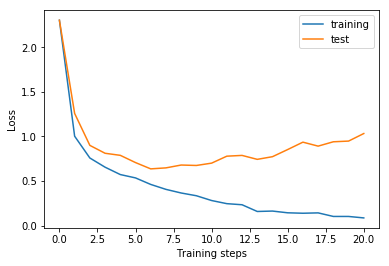

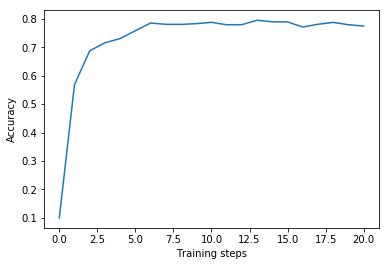

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
dense_block (DenseBlock)     multiple                  6228      
_________________________________________________________________
transition_layer (Transition multiple                  2544      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  7956      
_________________________________________________________________
transition_layer_1 (Transiti multiple                  6624      
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  13

In [28]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
model.summary()